# Algotrading

A pet project aimed at predicting a cryptocurrency price based on data from polymarket.com

## Problem definition


**Meta**: Try to make minimal possible solution & move to more complex ones if a simple one does not perform as we wish it to.

**A goal** is to check whether there is a correlation between crypto currencies (CC) price in the future with & polymarket polls about them.


## Available datapoints are


- CC price from Binance (target)

**Polymarket has polls of varying types**, but at its core, there is a single (Yes/No) bet. Polls of choice type are just an ordered list of (Yes/No) polls.

Some of the polls formats:
- (Choice) Price range prediction of CC at a time point
- (Choice) Min price pred. at a time point
- (Choice) When will a CC reach an all time high
- (Yes/No) Will a CC reach an all time high before some time point
- (Yes/No) Will a CC be above some price at a time point?
- etc.


**Each poll has these datapoints**:
- Total volume in USD
- End date
- For each option to make a bet on, there is a "chance" of it happening, computed using bets distribution.
- How "chance" of an event was changing over time (a graph, chart)
- Price for 100 shares. When placing a bet, user is buying shares. In the UI price per 100 shares is shown. Price of a single share varies between 0 and 1$. When a bet is resolved and user made a winning bet, every share is exchanged to 1$.
- Distribution of how much shares were purchased at what price for each betting option
- Comments on a poll. They can also be replies to top-level comments.
	- Content, text
	- Amount of likes
	- Shares he has on a poll. Note: multiple bets can be placed on a single poll. Total shares amount he has & for which option is shown. It means it is not shown how much money he spent, as share price has a varying price.
- 15 top holders of each option
- Recent activity: who purchased or sold shares and at what cost
- A list of related polls. Potentially, we could extract data from these polls too. For example, for a poll "Bitcoin above $105,000 on January 31?" its related bet can be "Will Bitcoin reach $110_000 by January 31, 2025"

**We can view top users** by their betting volume & profit. **Their bets could be mimiced**.
Looks like a bot to me: https://polymarket.com/profile/0x42a6ddf7cf7032972b0bfe32775e8109c5171b64?tab=activity


## Visual analysis


I've placed 2 charts side my side: BCT Price and Polymarket confidence in BTC hitting a price of $120k by March 31. Visually it can be seen that Polymarket roughly mimics the BTC price trend, which had never reached this price point, typically being in a range of $95k-$105k.

Notably, other polymerket polls - $110k, $130k, $150k, $200k have a similar shape, where bigger the poll price ($200k), less similar (mimicing its up's and down's) it is to a BTC price at that time.

Binance BTC Price Chart            |  Market confidence in "BTC will hit $120k by March 31" 
:-------------------------:|:-------------------------:
![image.png](../static/1_binance_btc_chart.png)  |  ![image.png](../static/1_polymarket_BTC_hit_120k.png)


Next observation is, that polls that bet on a lower outcome than the current price have a negative correlation, meaning that when more people bet "Yes" on $120k, more people vote "No" on $80k.

Market confidence in "BTC will hit $120k by March 31"
![image.png](../static/1_polymarket_BTC_hit_120k.png)  

Market confidence in "BTC will hit $80k by March 31"
![image.png](../static/1_polymarket_BTC_hit_80k.png)


In [ ]:
from dotenv import load_dotenv
import os

# Load environment variables
load_dotenv()
BINANCE_API_KEY = os.getenv("BINANCE_API_KEY")
BINANCE_API_SECRET = os.getenv("BINANCE_API_SECRET")


In [2]:
from binance import Client

client = Client(BINANCE_API_KEY, BINANCE_API_SECRET)

symbol = "BTCUSDT"  # or any other trading pair
interval = Client.KLINE_INTERVAL_1DAY

data = client.get_historical_klines(
    symbol=symbol, interval=interval, start_str="2024-12-13", end_str="2025-02-08"
)

columns = [
    "Open Time", "Open", "High", "Low", "Close", "Volume",
    "Close Time", "Quote Asset Volume", "Number of Trades",
    "Taker Buy Base Asset Volume", "Taker Buy Quote Asset Volume", "Ignore"
]

In [12]:
import pandas as pd

BTC_df = pd.DataFrame(data, columns=columns)

BTC_df['Open Time'] = pd.to_datetime(BTC_df['Open Time'], unit='ms')
BTC_df['Close Time'] = pd.to_datetime(BTC_df['Close Time'], unit='ms')

numeric_columns = ["Open", "High", "Low", "Close", "Volume", "Quote Asset Volume",
                   "Taker Buy Base Asset Volume", "Taker Buy Quote Asset Volume"]
BTC_df[numeric_columns] = BTC_df[numeric_columns].astype(float)

BTC_df["delta"] = BTC_df["Close"] - BTC_df["Open"]

BTC_df = BTC_df.set_index('Open Time')

BTC_df.head()

,Open,High,Low,Close,Volume,Close Time,Quote Asset Volume,Number of Trades,Taker Buy Base Asset Volume,Taker Buy Quote Asset Volume,Ignore,delta
Open Time,,,,,,,,,,,,
2024-12-13,100004.29,101895.26,99205.00,101424.25,21904.039230,2024-12-13 23:59:59.999,2.203903e+09,5481660,10669.093650,1.073721e+09,0,1419.96
2024-12-14,101424.24,102650.00,100609.41,101420.00,14191.703260,2024-12-14 23:59:59.999,1.441594e+09,3374538,6790.246760,6.899819e+08,0,-4.24
2024-12-15,101420.00,105250.00,101237.14,104463.99,22228.921775,2024-12-15 23:59:59.999,2.290463e+09,3638809,12668.894355,1.305611e+09,0,3043.99
2024-12-16,104463.99,107793.07,103333.00,106058.66,41302.402740,2024-12-16 23:59:59.999,4.364964e+09,8048054,20349.099500,2.150551e+09,0,1594.67
2024-12-17,106058.65,108353.00,105321.49,106133.74,29064.936466,2024-12-17 23:59:59.999,3.103833e+09,7212799,14187.320446,1.515158e+09,0,75.09


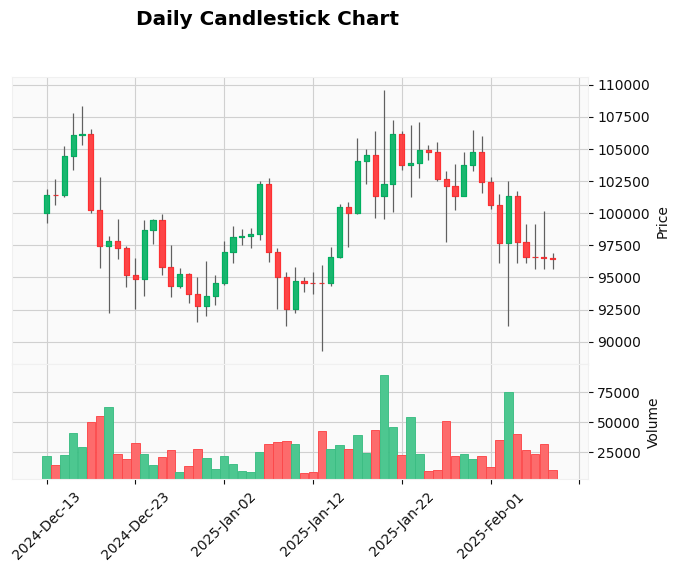

In [ ]:
import mplfinance as mpf

mpf.plot(BTC_df, type='candle', volume=True, title="Daily Candlestick Chart", style='yahoo')

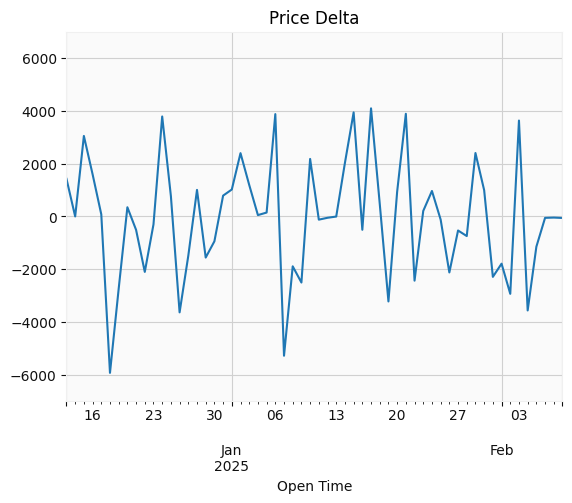

In [96]:
import matplotlib.pyplot as plt

ax = BTC_df['delta'].plot(title='Price Delta')
plt.ylim(-7000, 7000)
plt.show()

In [46]:
pm_df = pd.read_csv('../data/1_polymarket_BTC_1d.csv', parse_dates=['Date (UTC)'], index_col='Date (UTC)')

pm_df.rename(columns={"$150,000": "150", "$120,000": "120", "$80,000": "80", "$70,000": "70"}, inplace=True)

pm_prob_cols = ['150', '120', '80', '70'] 
pm_deltas_cols = [f'delta_{col}' for col in pm_prob_cols]
for column in ['150', '120', '80', '70']:
    # Compute how probability had changed after 1 day
    pm_df[f'open_{column}'] = pm_df[column]
    pm_df[f'close_{column}'] = pm_df[column].shift(-1)
    pm_df[f'delta_{column}'] = pm_df[f'close_{column}'] - pm_df[f'open_{column}']

pm_df.drop(columns=pm_prob_cols, inplace=True)

pm_df.head()

,Timestamp (UTC),open_150,close_150,delta_150,open_120,close_120,delta_120,open_80,close_80,delta_80,open_70,close_70,delta_70
Date (UTC),,,,,,,,,,,,,
2024-12-13,1734048003,0.305,0.240,-0.065,0.625,0.590,-0.035,NaN,0.410,NaN,NaN,0.185,NaN
2024-12-14,1734134403,0.240,0.235,-0.005,0.590,0.595,0.005,0.410,0.410,0.000,0.185,0.245,0.06
2024-12-15,1734220803,0.235,0.265,0.030,0.595,0.665,0.070,0.410,0.330,-0.080,0.245,0.175,-0.07
2024-12-16,1734307203,0.265,0.305,0.040,0.665,0.735,0.070,0.330,0.335,0.005,0.175,0.185,0.01
2024-12-17,1734393604,0.305,0.330,0.025,0.735,0.700,-0.035,0.335,0.320,-0.015,0.185,0.185,0.00


<Axes: title={'center': 'Polymarket Delta'}, xlabel='Date (UTC)'>

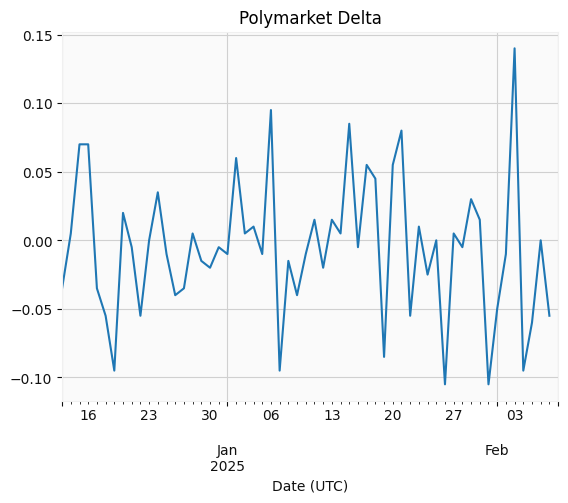

In [48]:
pm_df['delta_120'].plot(title='Polymarket Delta')

In [ ]:
from sklearn.preprocessing import MaxAbsScaler

deltas_df = pm_df[pm_deltas_cols].copy()
deltas_df['BTC_delta'] = BTC_df['delta']

# Scale daltas to (-1, 1) interval
scaler = MaxAbsScaler()
deltas_df[['BTC_delta']] = scaler.fit_transform(deltas_df[['BTC_delta']])
deltas_df[pm_deltas_cols] = scaler.fit_transform(deltas_df[pm_deltas_cols])

deltas_df.head()

,delta_150,delta_120,delta_80,delta_70,BTC_delta
Date (UTC),,,,,
2024-12-13,-1.000000,-0.250000,NaN,NaN,0.239465
2024-12-14,-0.076923,0.035714,0.000000,0.800000,-0.000715
2024-12-15,0.461538,0.500000,-0.727273,-0.933333,0.513344
2024-12-16,0.615385,0.500000,0.045455,0.133333,0.268928
2024-12-17,0.384615,-0.250000,-0.136364,0.000000,0.012663


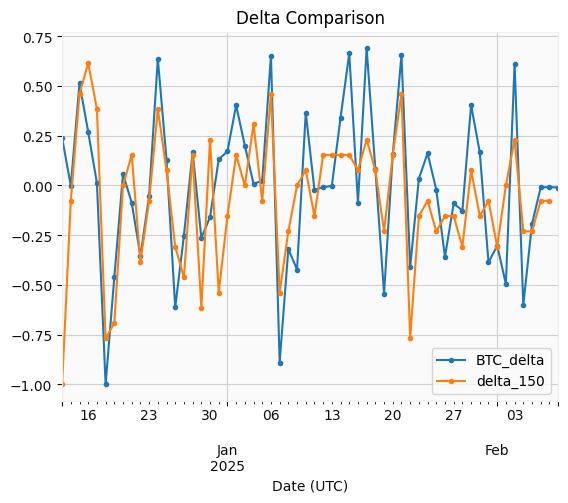

In [63]:
deltas_df[["BTC_delta", "delta_150"]].plot(style='.-', title='Delta Comparison')
plt.show()

In [103]:

corr_offsets = range(-10, 10)
corr_data = []
for col in pm_deltas_cols:
    col_corr_data = []
    for offset in corr_offsets:
        shifted_polymarket_delta = deltas_df[col].shift(offset)
        correlation_with_offset = deltas_df['BTC_delta'].corr(shifted_polymarket_delta)
        col_corr_data.append(correlation_with_offset)
        print(f"Corr with {col}, with offset {offset}: {correlation_with_offset}")
    corr_data.append(col_corr_data)
    print()



Corr with delta_150, with offset -10: 0.006439808806318175
Corr with delta_150, with offset -9: 0.13805846697753124
Corr with delta_150, with offset -8: -0.038435495636834204
Corr with delta_150, with offset -7: -0.24145322611891476
Corr with delta_150, with offset -6: -0.07040683078687099
Corr with delta_150, with offset -5: -0.16205822842546724
Corr with delta_150, with offset -4: 0.13857841735238244
Corr with delta_150, with offset -3: 0.036131547236175204
Corr with delta_150, with offset -2: -0.0804964941505829
Corr with delta_150, with offset -1: 0.11491115763271259
Corr with delta_150, with offset 0: 0.6340435682026516
Corr with delta_150, with offset 1: -0.026627035833461828
Corr with delta_150, with offset 2: -0.3171182231710475
Corr with delta_150, with offset 3: -0.09092563951175972
Corr with delta_150, with offset 4: 0.11368612089701813
Corr with delta_150, with offset 5: -0.005780159797691096
Corr with delta_150, with offset 6: -0.17804760835629202
Corr with delta_150, with

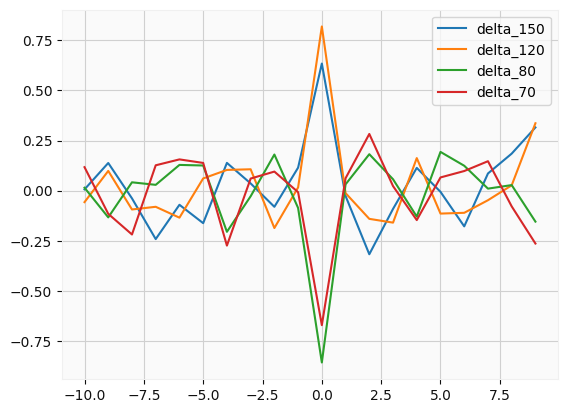

In [104]:
for i, col in enumerate(pm_deltas_cols):
    plt.plot(corr_offsets, corr_data[i], label=col)

plt.legend()

# Show the plot
plt.show()

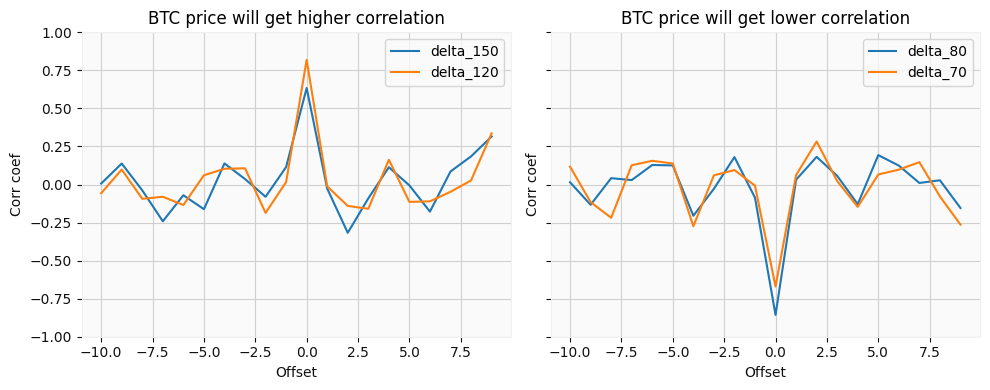

In [105]:
# Create two side-by-side plots
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(10, 4), sharey=True, sharex=True)

axes[0].plot(corr_offsets, corr_data[0], label="delta_150")
axes[0].plot(corr_offsets, corr_data[1], label="delta_120")
axes[0].set_title("BTC price will get higher correlation")
axes[0].set_xlabel("Offset")
axes[0].set_ylabel("Corr coef")
axes[0].legend()

axes[1].plot(corr_offsets, corr_data[2], label="delta_80")
axes[1].plot(corr_offsets, corr_data[3], label="delta_70")
axes[1].set_title("BTC price will get lower correlation")
axes[1].set_xlabel("Offset")
axes[1].set_ylabel("Corr coef")
axes[1].legend()

plt.ylim(-1, 1)
plt.tight_layout()
plt.show()

### Correlation plot interpretation

Plot was created using:
1. BTC price, that at the selected time interval was around $95k to $105k
2. Probability distribution of polymarket polls that BTC price will be $150k, $120k, $80k, $70k by March 31.

Plot is showing correlation coefficients on y axis between:
1. How much did BTC price change on a given day.
2. How much did probability distribution change on a given day.

With an offset value that is plotted on x axis.

At offset 0, there is a high positive correlation on bets that BTC will grow, and high negative correlation that BTC will loose in its price, which can indicate that market reponds to BTC's price change moderately reactively. Meaning that it mostly reacts to its changes day-by-day, which might indicate that there is no predictive power in this probability distribution.

At other offsets, the corr coef are negligibly small, though a sinusoid-like pattern is noticable.

TODO: Make plots with bigger and smaller time intervals.
